<a href="https://colab.research.google.com/github/VitorAvian/Visualizacao/blob/main/Visualiza%C3%A7%C3%A3o_Parte_1_e_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SCC0652 - Visualização Computacional
## Trabalho Prático - Parte 1
### Grupo 10: João Pedro Sousa dos Reis 9293373, Vitor Avian 10295392
---

Para a realização deste trabalho, foi escolhido o conjunto de dados "*World Happiness Report*" disponível no site Kaggle que pode ser encontrado no link a seguir:
[World Happiness Report](https://www.kaggle.com/unsdsn/world-happiness), as tabelas utilizadas estarão em anexo.

O Dataset de World Happiness Report é composto por 158 linhas, cada uma representando um país onde tal pesquisa foi feita. Para cada país temos a sua posição no rank global, o score da felicidade e outras métricas como nível de confiança no governo, liberdade, distopia residual e etc. O score de felicidade é montado somando todas as outras variáveis e quanto maior for, significa que a vida naquele país é mais feliz. 
Um campo com um significado mais complexo é o de distopia residual. Distopia é considerado como um país fictício que possui todas as piores notas de cada uma categoria, sendo o pior lugar para se viver possível. De tal forma, todos os outros países são considerados com esse e assim é obtido esse valor residual que demonstra como (através do tempo) aquele país é melhor do que o da distopia.


## Criação da base de dados

In [ ]:
import numpy as np
import pandas as pd 

#Leitura dos CSVs
happiness_2015 = pd.read_csv("2015.csv")
happiness_2016 = pd.read_csv("2016.csv")
happiness_2017 = pd.read_csv("2017.csv")
happiness_2018 = pd.read_csv("2018.csv")
happiness_2019 = pd.read_csv("2019.csv")

#Remoção de campos que não serão utilizados
del happiness_2015["Standard Error"]
del happiness_2016["Lower Confidence Interval"]
del happiness_2016["Upper Confidence Interval"]
del happiness_2017["Whisker.high"]
del happiness_2017["Whisker.low"]

#Renomear colunas que precisam
new_names = ["Happiness Rank", "Happiness Score", "Economy (GDP per Capita)", "Health (Life Expectancy)", "Trust (Government Corruption)", "Dystopia Residual"]
happiness_2017.rename(columns=dict(zip(happiness_2017.columns[[1, 2, 3, 5, 8, 9]], new_names)), inplace=True)
happiness_2018.rename(columns={"Country or region": "Country"}, inplace=True)
happiness_2019.rename(columns={"Country or region": "Country"}, inplace=True)

happiness_2018 = happiness_2018.reindex(columns=["Overall rank", "Country", "Score", "GDP per capita", "Social support", "Healthy life expectancy", "Freedom to make life choices", "Perceptions of corruption", "Generosity"])
happiness_2019 = happiness_2019.reindex(columns=["Overall rank", "Country", "Score", "GDP per capita", "Social support", "Healthy life expectancy", "Freedom to make life choices", "Perceptions of corruption", "Generosity"])


Para ser possível entender melhor a distruibuição das variáveis, das proporções de relação com os outros países e para facilitar na convergência de futuros modelos, optamos por realizar uma normalização em todas, o que facilitou muito o entendimento da diferença de cada quesito para os diferentes países.

In [ ]:
def normalizar(df, i):
  df.iloc[:,i:] = (df.iloc[:,i:] - df.iloc[:,i:].min())/(df.iloc[:,i:].max() - df.iloc[:,i:].min())
  df.iloc[:,i:]

In [ ]:
normalizar(happiness_2015, 4)
normalizar(happiness_2016, 5)
normalizar(happiness_2017, 3)
normalizar(happiness_2018, 3)
normalizar(happiness_2019, 3)

## Criação de uma coluna de nível de felicidade

Como o score de felicidade é obtido através da simples soma das outras variáveis, não faz sentido utilizar algum tipo de modelo para se prever esse variável. 

No entanto, visando no futuro utilizar algum algoritmo de classificação, para com base nas notas de cada quesito se determinar o nível de felicidade de um país, resolvemos aplicar uma categorização com base nos scores dos países.  

Esta coluna irá mostrar em que nível o score de felicidade do país está comparado com o range entre o maior e o menor score daquele ano. Com as possíveis opções = {High, Medium-High, Medium, Medium-Low, Low} onde High significa que o país tem um score alto e Low que seu score é baixo.

De tal forma será possível entendermos os fatores que fazem com que cada país faça parte de um nível de felicidade em específico.

In [ ]:
happiness_2015.insert(loc=3, column='Happiness Level', value=['' for i in range(happiness_2015.shape[0])])
happiness_2016.insert(loc=3, column='Happiness Level', value=['' for i in range(happiness_2016.shape[0])])
happiness_2017.insert(loc=3, column='Happiness Level', value=['' for i in range(happiness_2017.shape[0])])
happiness_2018.insert(loc=3, column='Happiness Level', value=['' for i in range(happiness_2018.shape[0])])
happiness_2019.insert(loc=3, column='Happiness Level', value=['' for i in range(happiness_2019.shape[0])])

### Função para atribuir os diferentes níveis ao score do país

A função a seguir irá calcular a diferença entre o melhor e o pior score do ano, e dividirá esse valor em 5 limites. A seguir, utilizando estes limites, iremos designar o nível para cada país.

In [ ]:
#recebe o dataframe, o campo da categoria e o campo do score e retorna um df com a categorizacoa
def categorize_hapinness(df, category, score):
  targets = ["High","Medium-High","Medium","Medium Low","Low"]
  ranger = (df.iloc[0,score] - df.iloc[-1,score])/5
  border = df.iloc[0,score] - ranger
  k = 0   
  for i in df.index:
    if  df.iloc[i, score] >= border:
      df.iloc[i, category] = targets[k]
    else: 
      df.iloc[i, category] = targets[k]
      k = k + 1 
      border = border - ranger 
  return df

In [ ]:
happiness_2015

,Country,Region,Happiness Rank,Happiness Level,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,,7.587,0.826132,0.962403,0.918244,0.993789,0.760595,0.372895,0.668630
1,Iceland,Western Europe,2,,7.561,0.770412,1.000000,0.924496,0.938841,0.256292,0.548198,0.725030
2,Denmark,Western Europe,3,,7.527,0.784113,0.970297,0.853099,0.969615,0.876175,0.428947,0.660889
3,Norway,Western Europe,4,,7.522,0.863099,0.949167,0.863409,1.000000,0.661394,0.435983,0.652724
4,Canada,North America,5,,7.427,0.784592,0.943219,0.883326,0.945112,0.597144,0.575602,0.648584
...,...,...,...,...,...,...,...,...,...,...,...,...
153,Rwanda,Sub-Saharan Africa,154,,3.465,0.131376,0.551764,0.418083,0.883953,1.000000,0.284314,0.104425
154,Benin,Sub-Saharan Africa,155,,3.340,0.169573,0.252355,0.311241,0.723426,0.145132,0.229432,0.398557
155,Syria,Middle East and Northern Africa,156,,3.006,0.392329,0.338668,0.704150,0.234184,0.342556,0.592790,0.000000
156,Burundi,Sub-Saharan Africa,157,,2.905,0.009051,0.296578,0.218444,0.176937,0.182312,0.247864,0.459573


In [ ]:
happiness_2015 = categorize_hapinness(happiness_2015, 3, 4)
happiness_2016 = categorize_hapinness(happiness_2016, 3, 4)
happiness_2017 = categorize_hapinness(happiness_2017, 3, 2)
happiness_2018 = categorize_hapinness(happiness_2018, 3, 2)
happiness_2019 = categorize_hapinness(happiness_2019, 3, 2)
happiness_2015.iloc[:,:5]

,Country,Region,Happiness Rank,Happiness Level,Happiness Score
0,Switzerland,Western Europe,1,High,7.587
1,Iceland,Western Europe,2,High,7.561
2,Denmark,Western Europe,3,High,7.527
3,Norway,Western Europe,4,High,7.522
4,Canada,North America,5,High,7.427
...,...,...,...,...,...
153,Rwanda,Sub-Saharan Africa,154,Low,3.465
154,Benin,Sub-Saharan Africa,155,Low,3.340
155,Syria,Middle East and Northern Africa,156,Low,3.006
156,Burundi,Sub-Saharan Africa,157,Low,2.905


## Designando as regiões nas tabelas onde não tem essa coluna

Na próxima sessão iremos criar dataframes para agrupar os dados por região, porém algumas tabelas estão sem essa coluna. Para isso criaremos colunas com a categoria "Other" como base.

Utilizaremos as informações já existentes nas tabelas de 2015 e 2016 para preencher a coluna de regiões dos outros anos por meio de merge.

In [ ]:
happiness_2017.insert(loc=1, column='Region', value=['Other' for i in range(happiness_2017.shape[0])])
happiness_2018.insert(loc=1, column='Region', value=['Other' for i in range(happiness_2018.shape[0])])
happiness_2019.insert(loc=1, column='Region', value=['Other' for i in range(happiness_2019.shape[0])])

A função a seguir irá utilizar uma dataframe auxiliar com o merge das tabelas sem a coluna "Region" com a dataframe que possui essa informação, para assim, preencher a coluna com as respectivas regiões.

In [ ]:
#recebe o dataframa que deseja adicionar as regiões, o dataframe com as regiões já definidas, os números das colunas em que estão o país e a região de cada dataframe
def categoriza_region(df, merger, country_df, country_merger, region_df, region_merger):
  aux = pd.merge(df, merger, on="Country")

  #percorre o merge auxiliar para armazenar as regiões corretas no dataframe
  for i in aux.index:
    if df.iloc[i, country_df] == aux.iloc[i, country_merger]:
      df.iloc[i, region_df] = aux.iloc[i, region_merger]
    else:
      k = i + 1;
      while df.iloc[k, country_df] != aux.iloc[i, country_merger]:
        k += 1
      df.iloc[k, region_df] = aux.iloc[i, region_merger]

  return df

Adicionando as informações das regiões presentes nas tabelas dos anos 2015 e 2016 no restante das tabelas.

In [ ]:
happiness_2017 = categoriza_region(happiness_2017, happiness_2015, 0, 0, 1, 12)
happiness_2017 = categoriza_region(happiness_2017, happiness_2016, 0, 0, 1, 12)
happiness_2018 = categoriza_region(happiness_2018, happiness_2015, 2, 2, 1, 11)
happiness_2018 = categoriza_region(happiness_2018, happiness_2016, 2, 2, 1, 11)
happiness_2019 = categoriza_region(happiness_2019, happiness_2015, 2, 2, 1, 11)
happiness_2019 = categoriza_region(happiness_2019, happiness_2016, 2, 2, 1, 11)

## Agrupando as médias dos atributos pela Região

Para realizar comparações futuras entre as regiões, agrupamos as médias dos atributos relevantes de cada ano pela coluna "Region".

In [ ]:
df_region_2015 = happiness_2015.groupby(['Region'], as_index=False).mean()
df_region_2016 = happiness_2016.groupby(['Region'], as_index=False).mean()
df_region_2017 = happiness_2017.groupby(['Region'], as_index=False).mean()
df_region_2018 = happiness_2018.groupby(['Region'], as_index=False).mean()
df_region_2019 = happiness_2019.groupby(['Region'], as_index=False).mean()
df_region_2015

,Region,Happiness Rank,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Australia and New Zealand,9.500000,7.285000,0.764236,0.937400,0.897308,0.963538,0.711701,0.572090,0.591642
1,Central and Eastern Europe,79.000000,5.332931,0.557517,0.750977,0.701072,0.534945,0.157043,0.191315,0.517119
2,Eastern Asia,64.500000,5.626167,0.681357,0.784056,0.855780,0.690562,0.231369,0.283818,0.413320
3,Latin America and Caribbean,46.909091,6.144682,0.518697,0.787831,0.686535,0.749167,0.212302,0.273644,0.700765
4,Middle East and Northern Africa,77.600000,5.406900,0.631188,0.656447,0.688238,0.540145,0.329224,0.239201,0.504475
5,North America,10.000000,7.273000,0.804770,0.916298,0.861946,0.880213,0.442527,0.539755,0.657497
6,Southeastern Asia,81.222222,5.317444,0.466780,0.670694,0.660675,0.831834,0.274095,0.526789,0.444299
7,Southern Asia,113.142857,4.580857,0.331566,0.460211,0.527510,0.557444,0.185783,0.428995,0.515704
8,Sub-Saharan Africa,127.900000,4.202800,0.225076,0.576999,0.275378,0.546405,0.224453,0.277852,0.516685
9,Western Europe,29.523810,6.689619,0.768209,0.889513,0.886757,0.821116,0.419385,0.379591,0.556765


## Mostrando a correlação dos atributos das tabelas

Montamos um gráfico das correlações dos dados para conseguir entender melhor qual o papel de cada variável no score de felicidade e de como cada uma impacta na outra. Com isso conseguimos perceber algumas coisas interessantes. Como por exemplo que a renda per capita é o quesito que mais possui impacto na felicidade e que quanto maior a renda, menor o nível de generosidade de um país.

In [ ]:
corr_2015 = happiness_2015.drop(happiness_2015.columns[2], axis = 1).corr()
corr_2016 = happiness_2016.drop(happiness_2016.columns[2], axis = 1).corr()
corr_2017 = happiness_2017.drop(happiness_2017.columns[2], axis = 1).corr()
corr_2018 = happiness_2018.drop(happiness_2018.columns[0], axis = 1).corr()
corr_2019 = happiness_2019.drop(happiness_2019.columns[0], axis = 1).corr()
corr_2015

,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
Happiness Score,1.000000,0.780966,0.740605,0.724200,0.568211,0.395199,0.180319,0.530474
Economy (GDP per Capita),0.780966,1.000000,0.645299,0.816478,0.370300,0.307885,-0.010465,0.040059
Family,0.740605,0.645299,1.000000,0.531104,0.441518,0.205605,0.087513,0.148117
Health (Life Expectancy),0.724200,0.816478,0.531104,1.000000,0.360477,0.248335,0.108335,0.018979
Freedom,0.568211,0.370300,0.441518,0.360477,1.000000,0.493524,0.373916,0.062783
Trust (Government Corruption),0.395199,0.307885,0.205605,0.248335,0.493524,1.000000,0.276123,-0.033105
Generosity,0.180319,-0.010465,0.087513,0.108335,0.373916,0.276123,1.000000,-0.101301
Dystopia Residual,0.530474,0.040059,0.148117,0.018979,0.062783,-0.033105,-0.101301,1.000000


In [ ]:
#Discarte das linhas que possuem dados null
happiness_2018 = happiness_2018.dropna()

# Parte 2





## Análise taxonômica
Considerando os conjuntos de dados happiness_20XX criados na última parte do trabalho podemos observar, por exemplo, a tabela happiness_2015, que possui colunas categóricas como "Contry", "Region" e "Happiness Level", e também possui colunas númericas como "Happiness Rank", "Happiness Score", etc. Assim podemos concluir que o conjunto de dados é do grupo **taxonômico híbrido**.

In [ ]:
happiness_2015

,Country,Region,Happiness Rank,Happiness Level,Happiness Score,Economy (GDP per Capita),Family,Health (Life Expectancy),Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,High,7.587,0.826132,0.962403,0.918244,0.993789,0.760595,0.372895,0.668630
1,Iceland,Western Europe,2,High,7.561,0.770412,1.000000,0.924496,0.938841,0.256292,0.548198,0.725030
2,Denmark,Western Europe,3,High,7.527,0.784113,0.970297,0.853099,0.969615,0.876175,0.428947,0.660889
3,Norway,Western Europe,4,High,7.522,0.863099,0.949167,0.863409,1.000000,0.661394,0.435983,0.652724
4,Canada,North America,5,High,7.427,0.784592,0.943219,0.883326,0.945112,0.597144,0.575602,0.648584
...,...,...,...,...,...,...,...,...,...,...,...,...
153,Rwanda,Sub-Saharan Africa,154,Low,3.465,0.131376,0.551764,0.418083,0.883953,1.000000,0.284314,0.104425
154,Benin,Sub-Saharan Africa,155,Low,3.340,0.169573,0.252355,0.311241,0.723426,0.145132,0.229432,0.398557
155,Syria,Middle East and Northern Africa,156,Low,3.006,0.392329,0.338668,0.704150,0.234184,0.342556,0.592790,0.000000
156,Burundi,Sub-Saharan Africa,157,Low,2.905,0.009051,0.296578,0.218444,0.176937,0.182312,0.247864,0.459573


## Mapeamentos visuais


Analisando os possíveis mapeamentos visuais para o nosso banco de dados híbrido chegamos a conclusão que havia duas principais interpretações dos dados que gostaríamos de mostrar:

1.   Mostrar o nível de felicidade dos países
2.   Como os diversos atributos numéricos impactam no score final de felicidade e no rank
3.   A correlação entre todos os valores numéricos (menos o rank)

Para o primeiro, concluimos que a melhor visulização seria através de mapas. Para o segundo consideramos o stacked barplot mais apropriado. 


### Gráfico de mapa

Um aspecto bastante interessante dos nosso dados é de que com ele é possível "contar diferentes histórias" com esse mesmo tema de felicidade. Com ele é possível mostrar a felicidade global, comparar a evolução ano a ano do score de cada país, analisar a felicidade por continente, entre outras possibilidades. Na maior parte dos casos, sempre trabalhamos com várias features numéricas (happiness score, economy, health) e algumas categóricas (país, região e happiness level) então podemos considerá-lo como híbrido. No entando, em alguns casos, quando as categorias mais relevantes são os países e a região é possível classifica-lo apenas como mapa.

Um dos mapeamentos visuais mais indicado para o nosso projeto é o gráfico de mapa do tipo choropeth. Nossos dados consiste em 150 linhas de países com cada um tendo o seu próprio happiness score. Dispor toda essa quantidade de informação em um gráfico e ser algo ainda visível é algo completamente problemático. No entando o tipo de gráfico escolhido resolve muito bem o problema por colocar os scores no "mundo real" através de um mapa, sendo fácil e agradavél observar toda essa quantidade de informação distribuída geograficamente. 

In [ ]:
#fazendo o import de novas livrarias
import plotly.graph_objects as go
import plotly.express as px

#para plotar em um mapa, precisamos do iso_alpha dos países
gapminder = px.data.gapminder()
data_mundi = gapminder[["country", "continent", "iso_alpha"]]
data_mundi = data_mundi.drop_duplicates()
data_mundi 

,country,continent,iso_alpha
0,Afghanistan,Asia,AFG
12,Albania,Europe,ALB
24,Algeria,Africa,DZA
36,Angola,Africa,AGO
48,Argentina,Americas,ARG
...,...,...,...
1644,Vietnam,Asia,VNM
1656,West Bank and Gaza,Asia,PSE
1668,"Yemen, Rep.",Asia,YEM
1680,Zambia,Africa,ZMB


In [ ]:
aux = data_mundi.merge(happiness_2019, left_on="country", right_on="Country", how = "left")
aux["Score"].fillna(0, inplace=True)
aux

,country,continent,iso_alpha,Overall rank,Region,Country,Score,Happiness Level,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Perceptions of corruption,Generosity
0,Afghanistan,Asia,AFG,154.0,Southern Asia,Afghanistan,3.203,Low,0.207838,0.318350,0.316389,0.000000,0.055188,0.279152
1,Albania,Europe,ALB,107.0,Central and Eastern Europe,Albania,4.719,Medium Low,0.562352,0.522167,0.765995,0.606973,0.059603,0.314488
2,Algeria,Africa,DZA,88.0,Middle East and Northern Africa,Algeria,5.211,Medium,0.595012,0.714286,0.687993,0.136292,0.251656,0.128975
3,Angola,Africa,AGO,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Argentina,Americas,ARG,47.0,Latin America and Caribbean,Argentina,6.086,Medium-High,0.648456,0.881773,0.772130,0.746434,0.110375,0.116608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Vietnam,Asia,VNM,94.0,Southeastern Asia,Vietnam,5.175,Medium,0.440024,0.828818,0.745837,0.860539,0.161148,0.259717
138,West Bank and Gaza,Asia,PSE,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
139,"Yemen, Rep.",Asia,YEM,NaN,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140,Zambia,Africa,ZMB,138.0,Sub-Saharan Africa,Zambia,4.107,Medium Low,0.343230,0.651478,0.373357,0.683043,0.192053,0.436396


In [ ]:
#função completa para plotar o mapa mundi

import plotly.graph_objects as go
import plotly.express as px

def plot_map(df, year):
  gapminder = px.data.gapminder()
  data_mundi = gapminder[["country", "continent", "iso_alpha"]]
  data_mundi = data_mundi.drop_duplicates()

  if(year > 2017):
    aux = data_mundi.merge(df, left_on="country", right_on="Country", how = "left")
    aux["Score"].fillna(0, inplace=True) 
    fig = go.Figure(data=go.Choropleth(
        locations = aux["iso_alpha"],
        z = aux['Score'], 
        text = aux['Country'],
        colorscale = 'Blues',
        autocolorscale=False,
        marker_line_color='darkgrey',
        marker_line_width=0.5,
        colorbar_title = 'Happiness Score',
    ))
  else:
    aux = data_mundi.merge(df, left_on="country", right_on="Country", how = "left")
    aux["Happiness Score"].fillna(0, inplace=True) 
    fig = go.Figure(data=go.Choropleth(
        locations = aux["iso_alpha"],
        z = aux['Happiness Score'], 
        text = aux['Country'],
        colorscale = 'Blues',
        autocolorscale=False,
        marker_line_color='darkgrey',
        marker_line_width=0.5,
        colorbar_title = 'Happiness Score',
    ))

  fig.update_layout(
      title_text='Gráfico da Felicidade Global '+ str(year),
      title_x= 0.48,
      title_xanchor= 'center',
      geo=dict(
          showframe=True,
          showcoastlines=True,
          projection_type='equirectangular'
      )
  )

  fig.show()

plot_map(happiness_2015, 2015)
plot_map(happiness_2016, 2016)
plot_map(happiness_2017, 2017)
plot_map(happiness_2018, 2018)
plot_map(happiness_2019, 2019)

Dispondo as informações desse jeito foi possível perceber uma desigualdade pelo mundo, com uma concentração de felicidade alta no mundo ocidental, principalmente nos países do norte. E notas baixas no continente africano e asiático.

### Stacked Barplot

Outra característica do nosso banco de dados é que ele possui diversos atributos que compõem outro atributo o “Happiness Score”, porém entender como esses atributos se comportam dentro de um mesmo score e qual a relação de importância que ele tem dentro de uma escala global e regional é difícil de se fazer sem ter alguma visualização auxiliar. 

Assim, escolhemos o stacked barplot para fazer essa interface, e decidimos utilizar as tabelas auxiliares das regiões agrupadas para termos uma amostra menor e para permitir uma análise mais clara dos dados. Ele permite que vejamos o todo pelas partes, podendo entender qual dos atributos está adicionando mais valor ao score da felicidade da região além de diferenciá-los por cores que facilita na análise.

Podemos observar no gráfico abaixo, que em 2015, os atributos que causaram maior impacto na maioria dos scores de felicidade das regiões foram a família e a economia. Também é possível observar que a generosidade tem um impacto maior nos países que têm as menores médias de felicidade. 


Obs: para executar essa parte do código deve-se desconsiderar o bloco de códigos com as normalizações (não executar os blocos de código da normalização antes do stacked_barplot)

In [ ]:
import plotly.graph_objects as go

def stacked_bar(df, year):
  if year < 2018:
    fig = go.Figure(data=[go.Bar(x = df["Region"].tolist(), y= df["Economy (GDP per Capita)"].tolist(), name='Economy'),
                        go.Bar(x= df["Region"].tolist(), y=df["Family"].tolist(), name='Family'),
                        go.Bar(x= df["Region"].tolist(), y=df["Health (Life Expectancy)"].tolist(), name='Health'),
                        go.Bar(x= df["Region"].tolist(), y=df["Freedom"].tolist(), name='Freedom'),
                        go.Bar(x= df["Region"].tolist(), y=df["Trust (Government Corruption)"].tolist(), name='Trust in Government'),
                        go.Bar(x= df["Region"].tolist(), y=df["Generosity"].tolist(), name='Generosity'),
                        go.Bar(x= df["Region"].tolist(), y=df["Dystopia Residual"].tolist(), name='Dystopia Residual')
    ])
    fig.update_layout(barmode='stack', 
                    xaxis={'categoryorder':'total descending'}, 
                    title = "Componentes do score de felicidade - " + str(year),
                    yaxis=dict(
                          title='Score de felicidade',
                          titlefont_size=16,
                          tickfont_size=14,
                    )
    )
  else:
    fig = go.Figure(data=[go.Bar(x = df["Region"].tolist(), y= df["GDP per capita"].tolist(), name='Economy'),
                        go.Bar(x= df["Region"].tolist(), y=df["Social support"].tolist(), name='Family'),
                        go.Bar(x= df["Region"].tolist(), y=df["Healthy life expectancy"].tolist(), name='Health'),
                        go.Bar(x= df["Region"].tolist(), y=df["Freedom to make life choices"].tolist(), name='Freedom'),
                        go.Bar(x= df["Region"].tolist(), y=df["Perceptions of corruption"].tolist(), name='Trust in Government'),
                        go.Bar(x= df["Region"].tolist(), y=df["Generosity"].tolist(), name='Generosity')
    ])
    fig.update_layout(barmode='stack', 
                    xaxis={'categoryorder':'total descending'}, 
                    title = "Componentes do score de felicidade - " + str(year),
                    yaxis=dict(
                          title='Score de felicidade relativo',
                          titlefont_size=16,
                          tickfont_size=14,
                    )
    )
  fig.show()


stacked_bar(df_region_2015, 2015)
stacked_bar(df_region_2016, 2016)
stacked_bar(df_region_2017, 2017)
stacked_bar(df_region_2018, 2018)
stacked_bar(df_region_2019, 2019)

### Matriz de correlação utilizando heatmap


Com a matriz de correlação podemos analisar o impacto e a relação dos dados numéricos em pares. A correlação mostra que quão mais próximo de 1 for a correlação maior é o impacto no crescimento númerico do par e quanto mais próximo de -1 esse crescimento é inverso. Assim olhando os gráficos podemos concluir, por exemplo, que o atributo que tem maior impacto no score de felicidade é a renda per capita, enquanto maior a renda menor é a generosidade de um país.

Optamos por dois gráficos diferentes da matriz de correlação pois o primeiro permite se ter uma resposta visual mais rápida, sem precisar saber do valor dos dados, pois além de colorir as posições ele também relaciona a posição com o valor através do tamanho. Porém, como a variação dos dados é muito pequena (casas decimais), o visual de algumas posições podem dificultar a compreensão.

Já o segundo gráfico, por apresentar os dados junto com o visual, pode trazer uma interpretação mais forte dos dados numéricos em si, além da ajuda visual. 

In [ ]:
!pip install heatmapz

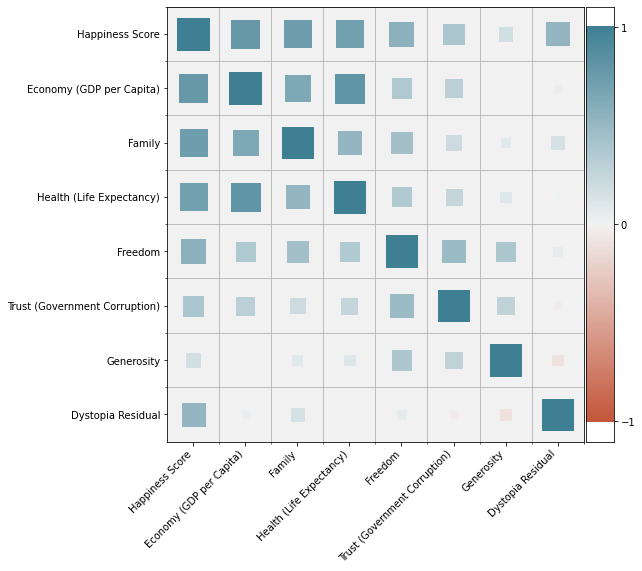

In [ ]:
from heatmap import heatmap, corrplot
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 8))
plt.title("Matriz de correlação para os atributos de " + str(2015))
corrplot(corr_2015, size_scale=1000);

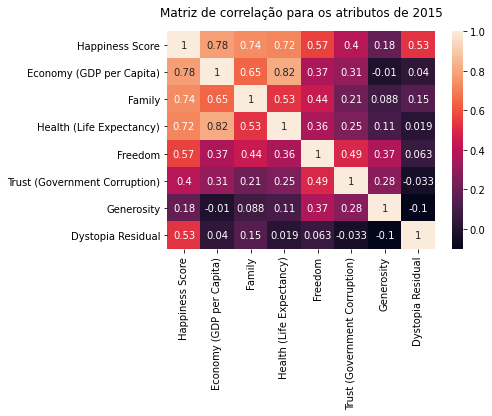

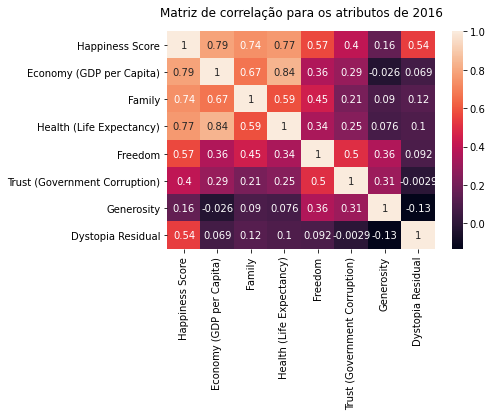

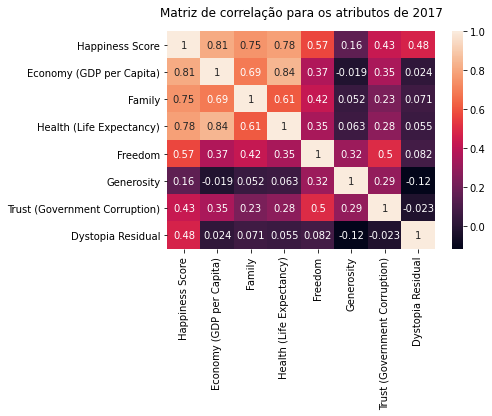

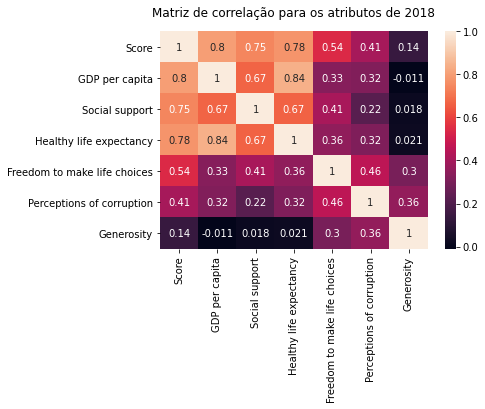

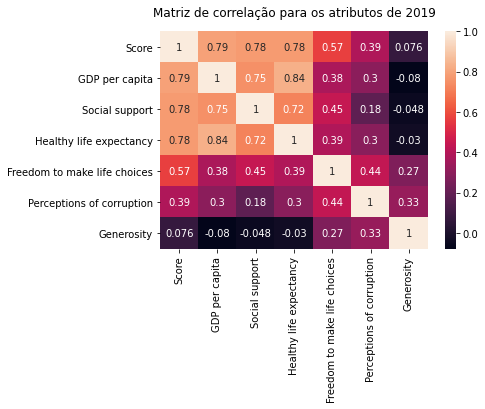

In [ ]:
def correlation(df, year):
  from matplotlib import pyplot as plt
  import seaborn as sn
  sn.heatmap(df, annot=True)
  plt.title("Matriz de correlação para os atributos de " + str(year), pad=15)
  plt.show()

correlation(corr_2015, 2015)
correlation(corr_2016, 2016)
correlation(corr_2017, 2017)
correlation(corr_2018, 2018)
correlation(corr_2019, 2019)